In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import gmaps
import scipy.stats as st
#from api_keys import g_key
import numpy as np
import seaborn as sns

In [5]:
# Import base data
complete_df = pd.read_csv('output/output_data_V2.csv')

In [7]:
# Separate data into winter/summer
winter_only = complete_df.loc[complete_df['Season']=='Winter',:]
summer_only = complete_df.loc[complete_df['Season']=='Summer',:]

#### Source data has all athlete medal counts.  Need to find Medals per Event in order to eliminate multiple medals for team events.

In [8]:
# Winter: create new columns for Gold, Silver, Bronze. Tally medal results into new columns
winter_medals = winter_only[['NOC','name','Year','Event','Medal','latitude','longitude']].copy()
for index, row in winter_medals.iterrows():
    if winter_medals.loc[index,'Medal'] == 'Gold':
        winter_medals.loc[index,'Gold'] = 1
    elif winter_medals.loc[index,'Medal'] == 'Silver':
        winter_medals.loc[index,'Silver'] = 1
    elif winter_medals.loc[index,'Medal'] == 'Bronze':
        winter_medals.loc[index,'Bronze'] = 1

In [9]:
# Summer: create new columns for Gold, Silver, Bronze. Tally medal results into new columns
summer_medals = summer_only[['NOC','name','Year','Event','Medal','latitude','longitude']].copy()
for index, row in summer_medals.iterrows():
    if summer_medals.loc[index,'Medal'] == 'Gold':
        summer_medals.loc[index,'Gold'] = 1
    elif summer_medals.loc[index,'Medal'] == 'Silver':
        summer_medals.loc[index,'Silver'] = 1
    elif summer_medals.loc[index,'Medal'] == 'Bronze':
        summer_medals.loc[index,'Bronze'] = 1

In [10]:
# Create new dataframes to average latitude and longitude
# Needed because some longitude values are not equal to all decimal places, resulting in incorrect groupby
winter_events = winter_medals.groupby(['NOC','name','Year','Event','latitude','longitude']).mean().reset_index()
summer_events = summer_medals.groupby(['NOC','name','Year','Event','latitude','longitude']).mean().reset_index()

In [11]:
# Create new dataframes
winter_noc = winter_events.groupby(['NOC','name','Year','latitude','longitude'])[['Gold','Silver','Bronze']].sum().reset_index()
summer_noc = summer_events.groupby(['NOC','name','Year','latitude','longitude'])[['Gold','Silver','Bronze']].sum().reset_index()

In [12]:
# Remove Summer years before 1924 to align with Winter years
summer_noc = summer_noc.loc[summer_noc['Year']>=1924,:].copy()

In [13]:
# Create new column to sum all medals won by event
winter_noc['Total Medals'] = winter_noc['Gold']+winter_noc['Silver']+winter_noc['Bronze']
summer_noc['Total Medals'] = summer_noc['Gold']+summer_noc['Silver']+summer_noc['Bronze']

In [14]:
# Sum total medals won by country
winter_df = winter_noc.groupby(['NOC','name','latitude','longitude'])['Gold','Silver','Bronze','Total Medals'].sum().reset_index()
summer_df = summer_noc.groupby(['NOC','name','latitude','longitude'])['Gold','Silver','Bronze','Total Medals'].sum().reset_index()

<ipython-input-14-bd787cfbd077>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  winter_df = winter_noc.groupby(['NOC','name','latitude','longitude'])['Gold','Silver','Bronze','Total Medals'].sum().reset_index()
<ipython-input-14-bd787cfbd077>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  summer_df = summer_noc.groupby(['NOC','name','latitude','longitude'])['Gold','Silver','Bronze','Total Medals'].sum().reset_index()


In [15]:
# Add new columns for percent of total medals won
total_medals_winter = winter_df['Total Medals'].sum()
total_medals_summer = summer_df['Total Medals'].sum()

winter_df['Medals Won %'] = winter_df['Total Medals']/total_medals_winter*100
summer_df['Medals Won %'] = summer_df['Total Medals']/total_medals_summer*100

# Heatmap - Medals Won %

In [16]:
gmaps.configure(api_key=g_key)
locations = winter_df[['latitude','longitude']]
w_medals = winter_df['Medals Won %']
winter = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(locations, weights=w_medals, dissipating=False, max_intensity=20, point_radius = 10)
winter.add_layer(heatmap_layer)
winter

NameError: name 'g_key' is not defined

In [17]:
gmaps.configure(api_key=g_key)
locations = summer_df[['latitude','longitude']]
s_medals = summer_df['Medals Won %']
summer = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(locations, weights=s_medals, dissipating=False, max_intensity=20, point_radius = 10)
summer.add_layer(heatmap_layer)
summer

NameError: name 'g_key' is not defined

# Scatter plot - Medals Won % vs Latitude

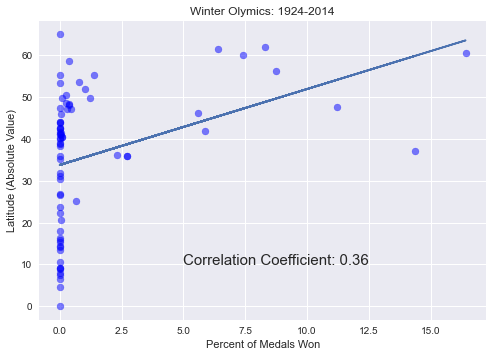

<Figure size 576x396 with 0 Axes>

In [27]:
medals_winter = winter_df['Medals Won %']
lat_winter = winter_df['latitude'].abs()
plt.scatter(medals_winter, lat_winter, facecolors="blue", alpha=0.5)

slope_w, intercept_w = st.linregress(medals_winter,lat_winter)[0:2]
line_w = slope_w*medals_winter+intercept_w
plt.title('Winter Olymics: 1924-2014')
plt.xlabel('Percent of Medals Won')
plt.ylabel('Latitude (Absolute Value)')
plt.style.use('seaborn')
plt.plot(medals_winter,line_w)

correlation_winter = f'Correlation Coefficient: {round(st.pearsonr(medals_winter, lat_winter)[0],2)}'


plt.text(5,10, correlation_winter, fontsize = 15)
plt.show()
plt.savefig('output/winter-latitude performance')

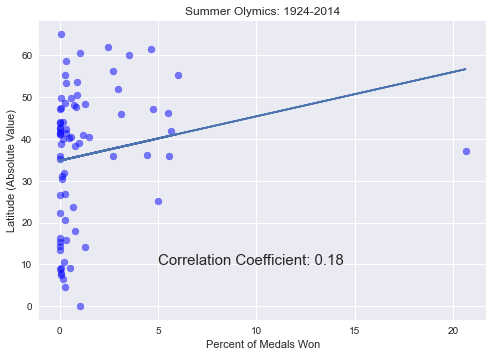

<Figure size 576x396 with 0 Axes>

In [28]:
medals_summer = summer_df['Medals Won %']
lat_summer = summer_df['latitude'].abs()
plt.scatter(medals_summer, lat_summer, marker="o", facecolors="blue", alpha=0.5)

slope_s, intercept_s = st.linregress(medals_summer,lat_summer)[0:2]
line_s = slope_s*medals_summer+intercept_s

plt.title('Summer Olymics: 1924-2014')
plt.xlabel('Percent of Medals Won')
plt.ylabel('Latitude (Absolute Value)')
plt.style.use('seaborn')

correlation_summer = f'Correlation Coefficient: {round(st.pearsonr(medals_summer, lat_summer)[0],2)}'
plt.text(5,10, correlation_summer, fontsize = 15)

plt.plot(medals_summer,line_s)
plt.show()
plt.savefig('output/summer-latitude performance')